In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

#Importing pytorch functions and modules
import torch
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms


import librosa
from librosa.core import stft,istft
from  sklearn.model_selection import train_test_split
from sklearn.metrics import *
from math import log

#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

GeForce GTX 1050


# Helper functions

In [2]:
#Uniform weight initilization
def weights_init_uniform_rule(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)
            
#Return negative of MSE, since we need a metric we can maximize            
def neg_mean_squared_error(y_true,y_pred):
    return((-1)*(mean_squared_error(y_true,y_pred)))

#Reproduce time domain signal from magnitude
def get_time_domain_signal(S,S_dir,length):
    S_complex = np.multiply(S,S_dir)
    return(istft(S_complex, hop_length=512, length = length))


#Calculate SNR of a predicted denoised signal by comparing to actual signal in time domain
def get_snr(s_actual,s_pred):
    num = np.dot(s_actual,s_actual)
    den = np.dot((s_actual-s_pred),(s_actual-s_pred))
    return(10*log(num/den,10))

# After training a neural network, this function uses the trained model object, 
# does a forward pass of the noisy sound and writes the predicted signal output
def clean_signal(input_file,output_file,model,device):
    """
    params :
    input_file = name of input wav file to read
    output_file = name of output wav file to write
    model = pretrained model object for prediction
    device = device(pytorch) on which model is trained
    """
    x, sr=librosa.load(input_file, sr=None)
    X_complex=stft(x, n_fft=1024, hop_length=512)
    X = np.abs(X_complex.T)


    X_dir = np.divide(X_complex,X.T)
    X = torch.tensor(X).to(device)
    D = X.shape[1]
    n_data = X.shape[0]

    X = X.reshape([n_data,1,D])

    X_clean_pred = model.forward(X).detach().cpu().numpy()

    x_clean_pred = get_time_domain_signal(X_clean_pred.T,X_dir,length=len(x))
    librosa.output.write_wav(output_file,x_clean_pred, sr)
    return

def clean_signal1(input_file,output_file,model,device):
    """
    params :
    input_file = name of input wav file to read
    output_file = name of output wav file to write
    model = pretrained model object for prediction
    device = device(pytorch) on which model is trained
    """
    x, sr=librosa.load(input_file, sr=None)
    X_complex=stft(x, n_fft=1024, hop_length=512)
    X = np.abs(X_complex.T)


    X_dir = np.divide(X_complex,X.T)
    X = torch.tensor(X).to(device)
    D = X.shape[1]
    n_data = X.shape[0]

    X = X.reshape([n_data,1,D])

    X_clean_pred = model.forward(X).detach().cpu().numpy()

    x_clean_pred = get_time_domain_signal(X_clean_pred.T,X_dir,length=len(x))
    librosa.output.write_wav(output_file,x_clean_pred, sr)
    return


# Custom function to train a pytorch neural network with early stopping 
# if validation score doesn't improve after 10 epochs
def train_neural_network(model,train_dataset,val_dataset,epochs,early_stopping_rounds,batch_size,
                         learning_rate,verbose,criterion,eval_func,device):
  
  
    #Dictionary where all the important outputs will be kept
    result_dict = dict()
    #Reading number of samples in each set
    n_train = len(train_dataset)
    n_val = len(val_dataset)

    # Data loader, using custom user provided batch size
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                                 batch_size=batch_size, 
                                                 shuffle=True)

    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                                 batch_size=n_val, 
                                                 shuffle=True)



    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


    # Train the model
    epoch=1
    stop=0
    best_performance = -100000
    rounds = 0
    stop = False
    model = model.to(device)

      #Training while loop 
    if(verbose==True):
        print("Training commenced")
    while ((epoch <= epochs)and(stop==False)):
        train_loss = 0
        for batch, labels in train_loader:  
            # Move tensors to GPU/CPU

            batch = batch.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model.forward(batch)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()


        with torch.no_grad():
            val_batch,val_labels = next(iter(val_loader))
            val_batch = val_batch.to(device)
            val_labels_pred = model.forward(val_batch).cpu().numpy()

            performance = eval_func(val_labels.cpu().numpy(),val_labels_pred)


        #Check if we have an increase in performance
        if(performance > best_performance):
            rounds = 0
            best_performance = performance
            best_prediction = val_labels_pred
            best_state_dict = model.state_dict()
            result_dict["train_loader"] = train_loader
            result_dict["val_batch"] = val_batch
            result_dict["val_labels"] = val_labels
            result_dict["best_model"] = model
            result_dict["val_labels_pred"] = best_prediction
            result_dict["best_performance"] = best_performance
        else:
            rounds += 1
            if(rounds == early_stopping_rounds):
                stop = True


        #Print statement, every 5 epochs or if it is the last epoch
        if(((epoch%5==0)|(stop==True))&(verbose==True)):
            print("EPOCH:"+str(epoch))
            if(stop==True):
                print("Training to be concluded after this epoch") 
            print("Average training loss per sample  = "+str(train_loss))
            print('Performance of the network in current epoch = '+str(round(performance,4)))
            print('Best performance of the network yet  = '+str(round(best_performance,4)))


        epoch += 1
    #While loop ends

    print("BEST SCORE IS:"+str(best_performance))
    return(result_dict)

# Problem-1

In [3]:
s, sr=librosa.load("train_clean_male.wav", sr=None)
S_complex=stft(s, n_fft=1024, hop_length=512)
x, sr=librosa.load("train_dirty_male.wav", sr=None)
X_complex=stft(x, n_fft=1024, hop_length=512)



print(X_complex.shape)
print(S_complex.shape)

X = np.abs(X_complex.T)
S = np.abs(S_complex.T)

X_dir = np.divide(X_complex,X.T)
X = torch.tensor(X).to(device)
S = torch.tensor(S).to(device)

print(X.shape)

(513, 2459)
(513, 2459)


RuntimeError: CUDA error: out of memory

In [ ]:
#Defining shapes
H = 1
D = X.shape[1]
K = 1

H_out = 1
D_out = S.shape[1]
K_out = 1
n_data = X.shape[0]

## Defining model class 
We calculate output shpaes based on the following formulae from Pytorch documentation
### Output size of 1D Convolution layer
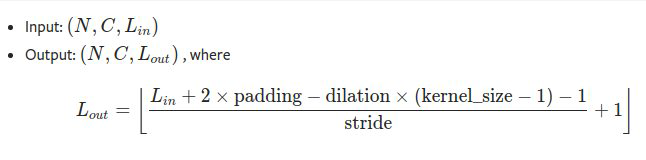
### Output size of 1D Maxpooling layer
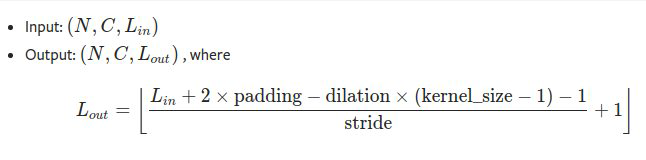

In [4]:
class Network1d(nn.Module):
    def __init__(
            self,
            K,
            H,
            D,
            K_out,
            H_out,
            D_out,
            dropout=0.2,
            stride=1,
    ):
        super(Network1d, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.relu = F.relu
        
        self.K_hidden1 = 5
        self.D_hidden1 = 256
        self.stride = stride
        self.maxp1_K = 2

        self.D_last = self.get_conv1d_shape(D_in=D,
                                            K_hidden=self.K_hidden1,
                                            D_hidden=self.D_hidden1,
                                            stride=self.stride,
                                            maxp_K=self.maxp1_K)
        
        self.conv1 = nn.Conv1d(in_channels=K,
                               out_channels=self.K_hidden1,
                               kernel_size=self.D_hidden1,
                               stride=self.stride)
        self.maxp1 = nn.MaxPool1d(kernel_size=2)
        self.D_linear = int((self.K_hidden1*self.D_last + D_out)/2)
        self.fc1 = nn.Linear(self.K_hidden1*self.D_last,self.D_linear)
        self.fc2 = nn.Linear(self.D_linear,D_out)
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxp1(x)
        x = self.dropout(x)
        
        x = x.view(-1,self.K_hidden1*self.D_last)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.relu(x)

        return(x)
    
    def get_conv1d_shape(self,D_in,K_hidden,D_hidden,stride,maxp_K):
        l_out = (D_in - (D_hidden-1) -1)/(stride) + 1
        l_out = int(l_out)
        l_ans = (l_out - (maxp_K-1) -1)/(maxp_K) + 1
        l_ans = int(l_ans)
        return(l_ans)

## Preparing data

In [6]:

from sklearn.model_selection import train_test_split
X = X.reshape([n_data,1,D])
S = S.reshape([n_data,D_out])

X_ind = np.array(range(0,n_data))
S_ind = np.array(range(0,n_data))

X_train_ind,X_val_ind,S_train_ind,S_val_ind = train_test_split(X_ind,S_ind,test_size=0.25,shuffle=True,random_state=SEED)
X_train = X[X_train_ind,:,:]
print(X_train.shape)
X_val = X[X_val_ind,:,:]
print(X_val.shape)
S_train = S[S_train_ind,:]
S_val = S[S_val_ind,:]

train_dataset = torch.utils.data.TensorDataset(X_train,S_train)
val_dataset = torch.utils.data.TensorDataset(X_val,S_val)



torch.Size([1844, 1, 513])
torch.Size([615, 1, 513])


## Training the network

In [7]:
#Defining hyper parameters 
batch_size = 200
dropout = 0
learning_rate = 0.001
epochs=200
early_stopping_rounds = 10
stride=1
criterion = nn.MSELoss()

cnn1d = Network1d(
            K=K,
            H=H,
            D=D,
            K_out=K_out,
            H_out=H_out,
            D_out=D_out,
            dropout=dropout,
    )
result_dict = train_neural_network(cnn1d,
                                   train_dataset,
                                   val_dataset,
                                   epochs,
                                   early_stopping_rounds,
                                   batch_size,
                                   learning_rate,
                                   verbose=True,
                                   criterion=criterion,
                                   eval_func=neg_mean_squared_error,
                                   device=device)     

Training commenced
EPOCH:5
Average training loss per sample  = 0.30138872284442186
Performance of the network in current epoch = -0.0354
Best performance of the network yet  = -0.0354
EPOCH:10
Average training loss per sample  = 0.14664417039602995
Performance of the network in current epoch = -0.0191
Best performance of the network yet  = -0.0191
EPOCH:15
Average training loss per sample  = 0.09563390910625458
Performance of the network in current epoch = -0.0146
Best performance of the network yet  = -0.0146
EPOCH:20
Average training loss per sample  = 0.07805062225088477
Performance of the network in current epoch = -0.0129
Best performance of the network yet  = -0.0129
EPOCH:25
Average training loss per sample  = 0.06004775548353791
Performance of the network in current epoch = -0.0114
Best performance of the network yet  = -0.0114
EPOCH:30
Average training loss per sample  = 0.05245628673583269
Performance of the network in current epoch = -0.0105
Best performance of the network y

## Validating result and writing output file

In [8]:
S_pred = cnn1d.forward(X).detach().cpu().numpy()
s_pred = get_time_domain_signal(S_pred.T,X_dir,length=len(x))
print("Mean Squared Error = "+str(mean_squared_error(S.cpu().numpy(),S_pred)))
print("SNR = "+str(get_snr(s,s_pred)))

Mean Squared Error = 0.0037034014
SNR = 14.686415151181784


In [9]:
clean_signal("train_dirty_male.wav","test_clean_male_pred_prob1.wav",cnn1d,device)
clean_signal("test_x_01.wav","test_x_01_pred_prob1.wav",cnn1d,device)
clean_signal("test_x_02.wav","test_x_02_pred_prob1.wav",cnn1d,device)

# Problem-2

In [3]:
s, sr=librosa.load("train_clean_male.wav", sr=None)
S_complex=stft(s, n_fft=1024, hop_length=512)
x, sr=librosa.load("train_dirty_male.wav", sr=None)
X_complex=stft(x, n_fft=1024, hop_length=512)



print(X_complex.shape)
print(S_complex.shape)

X = np.abs(X_complex.T)
S = np.abs(S_complex.T)

#unit direction vector of X(used in recreating sound signal from predicted output)
X_dir = np.divide(X_complex,X.T)


X = torch.tensor(X).to(device)
S = torch.tensor(S).to(device)

print(sr)

(513, 2459)
(513, 2459)
16000


## Defining model class
We caluclate output shapes based on the following formulae from Pytorch documentation
### Output of 2D convolution layer
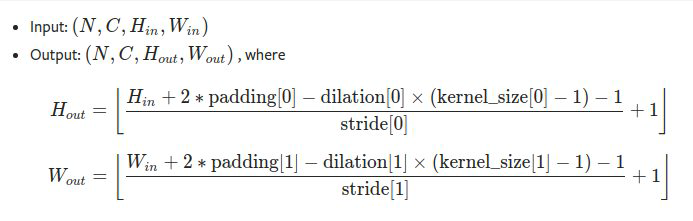
### Output of 2D Maxpooling layer
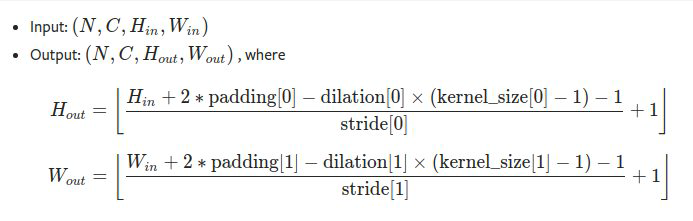

In [4]:
class Network2d(nn.Module):
    def __init__(
            self,
            K,
            H,
            D,
            D_out,
            dropout=0,
            stride=1,
    ):
        super(Network2d, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.relu = F.relu
        
        self.K_hidden1 = 5
        self.H_hidden1 = 10
        self.D_hidden1 = 256
        self.stride = stride
        self.maxp1_K = [2,2]


        self.conv1 = nn.Conv2d(in_channels=K,
                               out_channels=self.K_hidden1,
                               kernel_size=[self.H_hidden1,self.D_hidden1],
                               stride=self.stride)
        self.maxp1 = nn.MaxPool2d(kernel_size=self.maxp1_K)

        self.H_last,self.D_last = self.get_conv2d_shape(H_in=H,
                                           D_in=D,
                                           H_hidden = self.H_hidden1,
                                           D_hidden = self.D_hidden1,
                                           stride=self.stride,
                                           maxp_K=self.maxp1_K)

        self.fc1 = nn.Linear(self.K_hidden1*self.H_last*self.D_last,D_out)
        
        

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxp1(x)
        x = self.dropout(x)
        
        x = x.view(-1,self.K_hidden1*self.H_last*self.D_last)
        x = self.fc1(x)
        x = self.relu(x)
        
        return(x)
    
    def get_conv2d_shape(self,H_in,D_in,H_hidden,D_hidden,stride,maxp_K):
        h_out_c = (H_in - (H_hidden-1) - 1)/stride + 1
        d_out_c = (D_in - (D_hidden-1) - 1)/stride + 1
        
        h_out = (h_out_c - (maxp_K[0]-1) - 1)/maxp_K[0] + 1
        d_out = (d_out_c - (maxp_K[1]-1) - 1)/maxp_K[1] + 1
        return([int(h_out),int(d_out)])

## Preparing Data

In [5]:
#setting dimensions
frames_to_use = 20
H = frames_to_use
D = X.shape[1]
K = 1
D_out = S.shape[1]
n_data = X.shape[0] - (frames_to_use-1)




#Creating frames to train and test
X_dataset = torch.zeros([n_data,1,frames_to_use,D])
Y_dataset = torch.zeros([n_data,D_out])
for i in range(0,n_data):
    X_dataset[i,0,:,:]=X[i:i+frames_to_use,:]
    Y_dataset[i,:] = S[i+(frames_to_use-1),:]
X_dataset = X_dataset.to(device)
Y_dataset = Y_dataset.to(device)


#Train validation spllit
X_ind = np.array(range(0,n_data))
S_ind = np.array(range(0,n_data))
X_train_ind,X_val_ind,S_train_ind,S_val_ind = train_test_split(X_ind,S_ind,test_size=0.25,
                                                               shuffle=True,random_state=SEED)
X_train = X_dataset[X_train_ind,:,:,:]
X_val = X_dataset[X_val_ind,:,:,:]
S_train = Y_dataset[S_train_ind,:]
S_val = Y_dataset[S_val_ind,:]
train_dataset = torch.utils.data.TensorDataset(X_train,S_train)
val_dataset = torch.utils.data.TensorDataset(X_val,S_val)



## Training the model

In [6]:
#Defining hyper parameters 
batch_size = 150
dropout = 0
learning_rate = 0.001
stride=2


#Training thenetwork
criterion = nn.MSELoss()
cnn2d = Network2d( K=K,
            H=H,
            D=D,
            D_out=D_out,
            dropout=dropout,
            stride=stride).to(device)
cnn2d.apply(weights_init_uniform_rule)
result_dict = train_neural_network(cnn2d,
                                   train_dataset=train_dataset,
                                   val_dataset=val_dataset,
                                   epochs=200,
                                   early_stopping_rounds=10,
                                   batch_size=batch_size,
                                   learning_rate=learning_rate,
                                   verbose=True,
                                   criterion=criterion,
                                   eval_func=neg_mean_squared_error,
                                   device=device)    

Training commenced
EPOCH:5
Average training loss per sample  = 0.7956984955817461
Performance of the network in current epoch = -0.0691
Best performance of the network yet  = -0.0691
EPOCH:10
Average training loss per sample  = 0.6485619209706783
Performance of the network in current epoch = -0.061
Best performance of the network yet  = -0.061
EPOCH:15
Average training loss per sample  = 0.5709756202995777
Performance of the network in current epoch = -0.056
Best performance of the network yet  = -0.056
EPOCH:20
Average training loss per sample  = 0.4737137332558632
Performance of the network in current epoch = -0.0524
Best performance of the network yet  = -0.0524
EPOCH:25
Average training loss per sample  = 0.42210487835109234
Performance of the network in current epoch = -0.0507
Best performance of the network yet  = -0.0505
EPOCH:30
Average training loss per sample  = 0.3736446909606457
Performance of the network in current epoch = -0.0482
Best performance of the network yet  = -0.

In [7]:
S_pred = cnn2d.forward(X_dataset).detach().cpu().numpy()

#Appending randomly generated normal distribution numbers to first 19 frames
S_append= np.random.normal(loc=np.mean(S_pred),scale=np.std(S_pred),size=[19,513])
S_append[S_append<0]=0
S_pred = np.concatenate((S_append,S_pred),axis=0)
print(S_pred.shape)

s_pred = get_time_domain_signal(S_pred.T,X_dir,length=len(s))
print("Mean Squared Error = "+str(mean_squared_error(S.cpu().numpy(),S_pred)))
print("SNR = "+str(get_snr(s,s_pred)))

(2459, 513)
Mean Squared Error = 0.021543507320711374
SNR = 7.398769289501005


In [8]:
librosa.output.write_wav("test_clean_male_pred_prob2.wav",s_pred, sr)

### Similarly predicting for the other 2 signals

In [10]:
#Changing device since we are only doing forward pass
device = "cpu"
cnn2d = cnn2d.to(device)

In [12]:
# For test signal 1
x_test1,_ = librosa.load("test_x_01.wav", sr=sr)
X_test1_complex = stft(x_test1, n_fft=1024, hop_length=512)

X_test1 = np.abs(X_test1_complex.T)
X_test1_dir = np.divide(X_test1_complex,X_test1.T)

X_test1 = torch.tensor(X_test1).to(device)
n_test1_data = X_test1.shape[0] - (frames_to_use-1)

X_test1_dataset = torch.zeros([n_test1_data,1,frames_to_use,D])
for i in range(0,n_test1_data):
    X_test1_dataset[i,0,:,:]=X_test1[i:i+frames_to_use,:]
X_test1_dataset = X_test1_dataset.to(device)
S_test1 = cnn2d.forward(X_test1_dataset).detach().cpu().numpy()

#Appending randomly generated normal distribution numbers to first 19 frames
S_test1_append= np.random.normal(loc=np.mean(S_test1),scale=np.std(S_test1),size=[19,513])
S_test1_append[S_test1_append<0]=0
S_test1 = np.concatenate((S_test1_append,S_test1),axis=0)
s_test1 = get_time_domain_signal(S_test1.T,X_test1_dir,length=len(x_test1))
librosa.output.write_wav("test_x_01_pred_prob2.wav",s_test1, sr)

In [13]:
# For test signal 1
x_test2,_ = librosa.load("test_x_02.wav", sr=sr)
X_test2_complex = stft(x_test2, n_fft=1024, hop_length=512)

X_test2 = np.abs(X_test2_complex.T)
X_test2_dir = np.divide(X_test2_complex,X_test2.T)

X_test2 = torch.tensor(X_test2).to(device)
n_test2_data = X_test2.shape[0] - (frames_to_use-1)

X_test2_dataset = torch.zeros([n_test2_data,1,frames_to_use,D])
for i in range(0,n_test2_data):
    X_test2_dataset[i,0,:,:]=X_test2[i:i+frames_to_use,:]
X_test2_dataset = X_test2_dataset.to(device)
S_test2 = cnn2d.forward(X_test2_dataset).detach().cpu().numpy()

#Appending randomly generated normal distribution numbers to first 19 frames
S_test2_append= np.random.normal(loc=np.mean(S_test2),scale=np.std(S_test2),size=[19,513])
S_test2_append[S_test2_append<0]=0
S_test2 = np.concatenate((S_test2_append,S_test2),axis=0)
s_test2 = get_time_domain_signal(S_test2.T,X_test2_dir,length=len(x_test2))
librosa.output.write_wav("test_x_02_pred_prob2.wav",s_test2, sr)